# Local and Central DP with Fed-BioMed: MONAI 2d image registration

## Introduction

This tutorial shows how to deploy in Fed-BioMed the 2d image registration example provided in the project MONAI (https://monai.io/), trained with Differential Privacy (DP). We are going to compare results of:
* non private training
* train with Local Differential Privacy (LDP)
* train with Central Differential Privacy (CDP)

In order to enforce differential privacy during training (both local and central) we will rely on the Opcaus library (https://opacus.ai/). 

## Image Registration

Image registration is the process of transforming and recalibrating different images into one coordinate system. It makes possible to compare several images captured with the same modality.

In this tutorial, we are using a UNet-like registration network ( https://arxiv.org/abs/1711.01666 ).
Goal of the notebook is to train a model given moving images and fixed images (recalibrated images). 

## Start the network
Before running this notebook, start the network with `./scripts/fedbiomed_run network`

## Creating MedNIST nodes

MedNIST provides an artificial 2d classification dataset created by gathering different medical imaging datasets from TCIA, the RSNA Bone Age Challenge, and the NIH Chest X-ray dataset. The dataset is kindly made available by Dr. Bradley J. Erickson M.D., Ph.D. (Department of Radiology, Mayo Clinic) under the Creative Commons CC BY-SA 4.0 license.

To proceed with the tutorial, we created an iid partitioning of the MedNIST dataset between 3 clients. Each client has 3000 image samples for each class. The training partitions are availables at the following link:

https://drive.google.com/file/d/1vLIcBdtdAhh6K-vrgCFy_0Y55dxOWZwf/view

The dataset owned by each client has structure:


└── client_*/

    ├── AbdomenCT/
    
    └── BreastMRI/
    
    └── CXR/
    
    └── ChestCT/
    
    └── Hand/
    
    └── HeadCT/   

To create the federated dataset, we follow the standard procedure for node creation/population of Fed-BioMed. 
After activating the fedbiomed network with the commands

`source ./scripts/fedbiomed_environment network`

and 

`./scripts/fedbiomed_run network`

we create a first node by using the commands

`source ./scripts/fedbiomed_environment node`

`./scripts/fedbiomed_run node start`

We then poulate the node with the data of first client:

`./scripts/fedbiomed_run node add`

We select option 3 (images) to add MedNIST partition of client 1, by just picking the folder of client 1. 
Assign tag `mednist` to the data when asked.

We can further check that the data has been added by executing `./scripts/fedbiomed_run node list`

Following the same procedure, we create the other two nodes with the datasets of client 2 and client 3 respectively.


## Running Fed-BioMed Researcher

We are now ready to start the reseracher enviroment with the command `source ./scripts/fedbiomed_environment researcher`, and open the Jupyter notebook. 

We can first quesry the network for the mednist dataset. In this case, the nodes are sharing the respective partitions unsing the same tag `mednist`:

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fedbiomed.researcher.requests import Requests
req = Requests()
req.list(verbose=True)

2022-05-18 14:04:09,266 fedbiomed INFO - Component environment:
2022-05-18 14:04:09,268 fedbiomed INFO - type = ComponentType.RESEARCHER
2022-05-18 14:04:09,948 fedbiomed INFO - Messaging researcher_a6d0bb23-3a2b-4b60-a946-bf1ab60c50a6 successfully connected to the message broker, object = <fedbiomed.common.messaging.Messaging object at 0x1325918e0>
2022-05-18 14:04:10,038 fedbiomed INFO - Listing available datasets in all nodes... 
2022-05-18 14:04:20,095 fedbiomed INFO - 
 Node: node_facdad7d-e143-4834-b39b-fa3e26c86c2c | Number of Datasets: 1 
+---------+-------------+-------------+---------------+--------------------+
| name    | data_type   | tags        | description   | shape              |
+=========+=============+=============+===============+====================+
| mednist | images      | ['mednist'] | mednist       | [16954, 3, 64, 64] |
+---------+-------------+-------------+---------------+--------------------+

2022-05-18 14:04:20,097 fedbiomed INFO - 
 Node: node_95264f8

{'node_facdad7d-e143-4834-b39b-fa3e26c86c2c': [{'name': 'mednist',
   'data_type': 'images',
   'tags': ['mednist'],
   'description': 'mednist',
   'shape': [16954, 3, 64, 64]}],
 'node_95264f8a-8632-41ba-a510-9436d8fcebc1': [{'name': 'mednist',
   'data_type': 'images',
   'tags': ['mednist'],
   'description': 'mednist',
   'shape': [18000, 3, 64, 64]}],
 'node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca': [{'name': 'mednist',
   'data_type': 'images',
   'tags': ['mednist'],
   'description': 'mednist',
   'shape': [18000, 3, 64, 64]}]}

## Create an experiment to train a model on the data found

The code for network and data loader of the MONAI tutorial can now be deployed in Fed-BioMed.
We first import the necessary modules from `fedbiomed` and `monai` libraries:

In [3]:
from monai.utils import set_determinism, first
from monai.transforms import (
    EnsureChannelFirstD,
    Compose,
    LoadImageD,
    RandRotateD,
    RandZoomD,
    ScaleIntensityRanged,
    EnsureTypeD,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.config import print_config, USE_COMPILED
from monai.networks.nets import GlobalNet
from monai.networks.blocks import Warp
from monai.apps import MedNISTDataset

We can now define the training plan. Note that we use the standard `TorchTrainingPlan` natively provided in Fed-BioMed. We reuse the `MedNISTDataset` data loader defined in the original MONAI tutorial, which is returned by the method `training_data`, which also implements the data parsing from the nodes `dataset_path`. We should also properly define the `training_routine`, following the MONAI tutorial. According to the MONAI tutorial, the model is the `GlobalNet` and the loss is `MSELoss`.

In [4]:
import os
import numpy as np
import torch
from torch.nn import MSELoss
import torch.nn as nn
from fedbiomed.common.training_plans import TorchTrainingPlan
from fedbiomed.common.logger import logger
from fedbiomed.common.data import DataManager
from torchvision import datasets, transforms
from typing import Union, List
from opacus.validators import ModuleValidator
#from torch.utils.data import Dataset, DataLoader
import monai
from monai.utils import set_determinism, first
from monai.transforms import (
    EnsureChannelFirstD,
    Compose,
    LoadImageD,
    RandRotateD,
    RandZoomD,
    ScaleIntensityRanged,
    EnsureTypeD,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.config import print_config, USE_COMPILED
from monai.networks.nets import GlobalNet
from monai.networks.blocks import Warp
from monai.apps import MedNISTDataset


# Here we define the model to be used. 
class MyTrainingPlan(TorchTrainingPlan):
    def __init__(self, model_args: dict = {}):
        super(MyTrainingPlan, self).__init__(model_args)
        
        # Here we define the custom dependencies that will be needed by our custom Dataloader
        # In this case, we need the torch DataLoader classes
        # Since we will train on MNIST, we need datasets and transform from torchvision
        deps = ["import numpy as np",
                "import monai",
                "from torch.nn import MSELoss",
                "from monai.utils import set_determinism, first",
                "from monai.transforms import (EnsureChannelFirstD,Compose,LoadImageD,RandRotateD,RandZoomD,ScaleIntensityRanged,EnsureTypeD,)",
                "from monai.data import DataLoader, Dataset, CacheDataset",
                "from monai.networks.nets import GlobalNet",
                "from monai.config import USE_COMPILED",
                "from monai.networks.blocks import Warp",
                "from monai.apps import MedNISTDataset",
                "from opacus.validators import ModuleValidator"]
        self.add_dependency(deps)
        
        self.model = GlobalNet(
            image_size=(64, 64),
            spatial_dims=2,
            in_channels=2,  # moving and fixed
            num_channel_initial=16,
            depth=3)
        self.image_loss = MSELoss()
        
        if USE_COMPILED:
            self.warp_layer = Warp(3, "border")
        else:
            self.warp_layer = Warp("bilinear", "border")
        
        if (('DP' in model_args) and (model_args['DP']==True)):
            self.validate_and_fix_model()
            
    def make_optimizer(self,lr):
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

    def validate_and_fix_model(self):
        # Validate and Fix model to be DP-compliant
        if not ModuleValidator.is_valid(self.model):
            print('######################################## Fixing Model ########################################')
            self.model = ModuleValidator.fix(self.model)

    def training_data(self, batch_size = 20):
        # Custom torch Dataloader for MedNIST data
        data_path = self.dataset_path
        # The following line is needed if client structure does not contain the "/MedNIST" folder
        MedNISTDataset.dataset_folder_name = ""
        train_data = MedNISTDataset(root_dir=data_path, section="training", download=False, transform=None)
        training_datadict = [
            {"fixed_hand": item["image"], "moving_hand": item["image"]}
            for item in train_data.data if item["label"] == 4  # label 4 is for xray hands
        ]
        train_transforms = Compose(
            [
                LoadImageD(keys=["fixed_hand", "moving_hand"]),
                EnsureChannelFirstD(keys=["fixed_hand", "moving_hand"]),
                ScaleIntensityRanged(keys=["fixed_hand", "moving_hand"],
                                     a_min=0., a_max=255., b_min=0.0, b_max=1.0, clip=True,),
                RandRotateD(keys=["moving_hand"], range_x=np.pi/4, prob=1.0, keep_size=True, mode="bicubic"),
                RandZoomD(keys=["moving_hand"], min_zoom=0.9, max_zoom=1.1,
                          monaiprob=1.0, mode="bicubic", align_corners=False),
                EnsureTypeD(keys=["fixed_hand", "moving_hand"]),
            ]
        )
        train_ds = CacheDataset(data=training_datadict[:1000], transform=train_transforms,
                                cache_rate=1.0, num_workers=0)
        dl = self.MednistDataLoader(train_ds)
        
        return DataManager(dl, batch_size=batch_size, shuffle=True, num_workers=0)

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, moving, fixed):
        ddf = self.forward(torch.cat((moving, fixed), dim=1))
        pred_image = self.warp_layer(moving, ddf)
        loss = self.image_loss(pred_image, fixed)
        return loss
    
    class MednistDataLoader(monai.data.Dataset):
        # Custom DataLoader that inherits from monai's Dataset object
        def __init__(self, dataset):
            self.dataset = dataset

        def __len__(self):
            return len(self.dataset)

        def __getitem__(self, idx):
            return (self.dataset[idx]["moving_hand"],
                    self.dataset[idx]["fixed_hand"])

Finally we import the required modules for running any experiment

In [5]:
from fedbiomed.researcher.experiment import Experiment
from fedbiomed.researcher.aggregators.fedavg import FedAverage

# Non-private training

We first train our model in a non-private way. We set the model and training parameters. In particular, we are going to perform 2 epochs over 3 rounds for this experiment. Moreover the training is performed on ~26% of the locally available training data. We are also trying to use GPU if available.

In [6]:
batch_size = 42

model_args = {'use_gpu': True}

training_args = {
    'batch_size': batch_size, 
    'lr': 1e-5, 
    'epochs': 3, 
    'dry_run': False,  
    'batch_maxnum':200 # Fast pass for development : only use ( batch_maxnum * batch_size ) samples
}

tags =  ['mednist']
rounds = 5

The experiment can be now defined, by providing the `mednist` tag, and running the local training on nodes with model defined in `model_path`, standard `aggregator` (FedAvg) and `client_selection_strategy` (all nodes used). Federated learning is going to be perfomed through 3 optimization rounds.

In [7]:
exp = Experiment(tags=tags,
                 model_args=model_args,
                 model_class=MyTrainingPlan,
                 training_args=training_args,
                 round_limit=rounds,
                 aggregator=FedAverage(),
                 node_selection_strategy=None
                )

2022-05-18 14:04:23,077 fedbiomed INFO - Searching dataset with data tags: ['mednist'] for all nodes
05/18/2022 14:04:23:INFO:Searching dataset with data tags: ['mednist'] for all nodes
2022-05-18 14:04:33,098 fedbiomed INFO - Node selected for training -> node_facdad7d-e143-4834-b39b-fa3e26c86c2c
05/18/2022 14:04:33:INFO:Node selected for training -> node_facdad7d-e143-4834-b39b-fa3e26c86c2c
2022-05-18 14:04:33,102 fedbiomed INFO - Node selected for training -> node_95264f8a-8632-41ba-a510-9436d8fcebc1
05/18/2022 14:04:33:INFO:Node selected for training -> node_95264f8a-8632-41ba-a510-9436d8fcebc1
2022-05-18 14:04:33,105 fedbiomed INFO - Node selected for training -> node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca
05/18/2022 14:04:33:INFO:Node selected for training -> node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca
2022-05-18 14:04:33,134 fedbiomed INFO - Checking data quality of federated datasets...
05/18/2022 14:04:33:INFO:Checking data quality of federated datasets...
/Users/balelli/miniconda

Let's start the experiment.

By default, this function doesn't stop until all the `round_limit` rounds are done for all the clients



In [8]:
exp.run()

2022-05-18 14:04:35,976 fedbiomed INFO - Sampled nodes in round 0 ['node_facdad7d-e143-4834-b39b-fa3e26c86c2c', 'node_95264f8a-8632-41ba-a510-9436d8fcebc1', 'node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca']
05/18/2022 14:04:35:INFO:Sampled nodes in round 0 ['node_facdad7d-e143-4834-b39b-fa3e26c86c2c', 'node_95264f8a-8632-41ba-a510-9436d8fcebc1', 'node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca']
2022-05-18 14:04:35,983 fedbiomed INFO - Sending request 
					 To: node_facdad7d-e143-4834-b39b-fa3e26c86c2c 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_a6d0bb23-3a2b-4b60-a946-bf1ab60c50a6', 'job_id': '3fd0f4d4-3709-487a-82fd-a24c594e691f', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 42, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 200}, 'training': True, 'model_args': {'use_gpu': True}, 'command': 'train', 'model_url': 'http://local

05/18/2022 14:04:38:INFO:WARNING
					 NODE node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca
					 MESSAGE: There is no test activated for the round. Please set flag for `test_on_global_updates`, `test_on_local_updates`, or both. Splitting dataset for testing will be ignored
-----------------------------------------------------------------
2022-05-18 14:04:38,792 fedbiomed INFO - WARNING
					 NODE node_facdad7d-e143-4834-b39b-fa3e26c86c2c
					 MESSAGE: There is no test activated for the round. Please set flag for `test_on_global_updates`, `test_on_local_updates`, or both. Splitting dataset for testing will be ignored
-----------------------------------------------------------------
05/18/2022 14:04:38:INFO:WARNING
					 NODE node_facdad7d-e143-4834-b39b-fa3e26c86c2c
					 MESSAGE: There is no test activated for the round. Please set flag for `test_on_global_updates`, `test_on_local_updates`, or both. Splitting dataset for testing will be ignored
---------------------------------------------

05/18/2022 14:05:45:INFO:TRAINING 
					 NODE_ID: node_facdad7d-e143-4834-b39b-fa3e26c86c2c 
					 Epoch: 2 | Completed: 420/1000 (42%) 
 					 Loss: 0.046002 
					 ---------
2022-05-18 14:05:46,412 fedbiomed INFO - TRAINING 
					 NODE_ID: node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca 
					 Epoch: 2 | Completed: 420/1000 (42%) 
 					 Loss: 0.051748 
					 ---------
05/18/2022 14:05:46:INFO:TRAINING 
					 NODE_ID: node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca 
					 Epoch: 2 | Completed: 420/1000 (42%) 
 					 Loss: 0.051748 
					 ---------
2022-05-18 14:06:02,827 fedbiomed INFO - TRAINING 
					 NODE_ID: node_95264f8a-8632-41ba-a510-9436d8fcebc1 
					 Epoch: 2 | Completed: 840/1000 (83%) 
 					 Loss: 0.045726 
					 ---------
05/18/2022 14:06:02:INFO:TRAINING 
					 NODE_ID: node_95264f8a-8632-41ba-a510-9436d8fcebc1 
					 Epoch: 2 | Completed: 840/1000 (83%) 
 					 Loss: 0.045726 
					 ---------
2022-05-18 14:06:03,093 fedbiomed INFO - TRAINING 
					 NODE_ID: node_facdad7d-e143-483

2022-05-18 14:07:07,619 fedbiomed DEBUG - upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/experiments/Experiment_0000/aggregated_params_815ac217-31a9-4004-829a-d6381530378b.pt successful, with status code 201
05/18/2022 14:07:07:DEBUG:upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/experiments/Experiment_0000/aggregated_params_815ac217-31a9-4004-829a-d6381530378b.pt successful, with status code 201
2022-05-18 14:07:07,621 fedbiomed INFO - Saved aggregated params for round 0 in /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/experiments/Experiment_0000/aggregated_params_815ac217-31a9-4004-829a-d6381530378b.pt
05/18/2022 14:07:07:INFO:Saved aggregated params for round 0 in /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/experiments/Experiment_0000/aggregated_params_815ac217-31a9-4004-829a-d6381530378b.pt
2022-05-18 14:07:07,624 fedbiomed INFO - Sampled nodes in round 

05/18/2022 14:07:08:INFO:WARNING
					 NODE node_facdad7d-e143-4834-b39b-fa3e26c86c2c
					 MESSAGE: There is no test activated for the round. Please set flag for `test_on_global_updates`, `test_on_local_updates`, or both. Splitting dataset for testing will be ignored
-----------------------------------------------------------------
2022-05-18 14:07:08,283 fedbiomed INFO - WARNING
					 NODE node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca
					 MESSAGE: There is no test activated for the round. Please set flag for `test_on_global_updates`, `test_on_local_updates`, or both. Splitting dataset for testing will be ignored
-----------------------------------------------------------------
05/18/2022 14:07:08:INFO:WARNING
					 NODE node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca
					 MESSAGE: There is no test activated for the round. Please set flag for `test_on_global_updates`, `test_on_local_updates`, or both. Splitting dataset for testing will be ignored
---------------------------------------------

05/18/2022 14:07:52:INFO:TRAINING 
					 NODE_ID: node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca 
					 Epoch: 1 | Completed: 840/1000 (83%) 
 					 Loss: 0.053604 
					 ---------
2022-05-18 14:08:17,222 fedbiomed INFO - TRAINING 
					 NODE_ID: node_facdad7d-e143-4834-b39b-fa3e26c86c2c 
					 Epoch: 2 | Completed: 420/1000 (42%) 
 					 Loss: 0.048334 
					 ---------
05/18/2022 14:08:17:INFO:TRAINING 
					 NODE_ID: node_facdad7d-e143-4834-b39b-fa3e26c86c2c 
					 Epoch: 2 | Completed: 420/1000 (42%) 
 					 Loss: 0.048334 
					 ---------
2022-05-18 14:08:17,278 fedbiomed INFO - TRAINING 
					 NODE_ID: node_95264f8a-8632-41ba-a510-9436d8fcebc1 
					 Epoch: 2 | Completed: 420/1000 (42%) 
 					 Loss: 0.050303 
					 ---------
05/18/2022 14:08:17:INFO:TRAINING 
					 NODE_ID: node_95264f8a-8632-41ba-a510-9436d8fcebc1 
					 Epoch: 2 | Completed: 420/1000 (42%) 
 					 Loss: 0.050303 
					 ---------
2022-05-18 14:08:17,741 fedbiomed INFO - TRAINING 
					 NODE_ID: node_d201da5b-e239-4f5

2022-05-18 14:09:28,394 fedbiomed DEBUG - upload (HTTP GET request) of file node_params_05a8c2a3-ca85-427b-b68f-dd428018635a.pt successful, with status code 200
05/18/2022 14:09:28:DEBUG:upload (HTTP GET request) of file node_params_05a8c2a3-ca85-427b-b68f-dd428018635a.pt successful, with status code 200
2022-05-18 14:09:28,427 fedbiomed INFO - Nodes that successfully reply in round 1 ['node_facdad7d-e143-4834-b39b-fa3e26c86c2c', 'node_95264f8a-8632-41ba-a510-9436d8fcebc1', 'node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca']
05/18/2022 14:09:28:INFO:Nodes that successfully reply in round 1 ['node_facdad7d-e143-4834-b39b-fa3e26c86c2c', 'node_95264f8a-8632-41ba-a510-9436d8fcebc1', 'node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca']
2022-05-18 14:09:28,958 fedbiomed DEBUG - upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/experiments/Experiment_0000/aggregated_params_fc31d6fd-45e3-48ed-ab58-029cde68244f.pt successful, with status code 201
05/18/2022 14:09:

2022-05-18 14:09:28,984 fedbiomed DEBUG - researcher_a6d0bb23-3a2b-4b60-a946-bf1ab60c50a6
05/18/2022 14:09:28:DEBUG:researcher_a6d0bb23-3a2b-4b60-a946-bf1ab60c50a6
2022-05-18 14:09:29,349 fedbiomed INFO - WARNING
					 NODE node_facdad7d-e143-4834-b39b-fa3e26c86c2c
					 MESSAGE: There is no test activated for the round. Please set flag for `test_on_global_updates`, `test_on_local_updates`, or both. Splitting dataset for testing will be ignored
-----------------------------------------------------------------
05/18/2022 14:09:29:INFO:WARNING
					 NODE node_facdad7d-e143-4834-b39b-fa3e26c86c2c
					 MESSAGE: There is no test activated for the round. Please set flag for `test_on_global_updates`, `test_on_local_updates`, or both. Splitting dataset for testing will be ignored
-----------------------------------------------------------------
2022-05-18 14:09:29,355 fedbiomed INFO - WARNING
					 NODE node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca
					 MESSAGE: There is no test activated for th

2022-05-18 14:10:11,222 fedbiomed INFO - TRAINING 
					 NODE_ID: node_facdad7d-e143-4834-b39b-fa3e26c86c2c 
					 Epoch: 1 | Completed: 840/1000 (83%) 
 					 Loss: 0.040076 
					 ---------
05/18/2022 14:10:11:INFO:TRAINING 
					 NODE_ID: node_facdad7d-e143-4834-b39b-fa3e26c86c2c 
					 Epoch: 1 | Completed: 840/1000 (83%) 
 					 Loss: 0.040076 
					 ---------
2022-05-18 14:10:11,463 fedbiomed INFO - TRAINING 
					 NODE_ID: node_95264f8a-8632-41ba-a510-9436d8fcebc1 
					 Epoch: 1 | Completed: 840/1000 (83%) 
 					 Loss: 0.041802 
					 ---------
05/18/2022 14:10:11:INFO:TRAINING 
					 NODE_ID: node_95264f8a-8632-41ba-a510-9436d8fcebc1 
					 Epoch: 1 | Completed: 840/1000 (83%) 
 					 Loss: 0.041802 
					 ---------
2022-05-18 14:10:40,164 fedbiomed INFO - TRAINING 
					 NODE_ID: node_facdad7d-e143-4834-b39b-fa3e26c86c2c 
					 Epoch: 2 | Completed: 420/1000 (42%) 
 					 Loss: 0.041228 
					 ---------
05/18/2022 14:10:40:INFO:TRAINING 
					 NODE_ID: node_facdad7d-e143-483

05/18/2022 14:11:54:DEBUG:upload (HTTP GET request) of file node_params_45eac129-093f-4a98-b541-a5259f865bcf.pt successful, with status code 200
2022-05-18 14:11:54,400 fedbiomed INFO - Downloading model params after training on node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca - from http://localhost:8844/media/uploads/2022/05/18/node_params_cf6c1311-b81c-420c-945a-706bed5d2fb9.pt
05/18/2022 14:11:54:INFO:Downloading model params after training on node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca - from http://localhost:8844/media/uploads/2022/05/18/node_params_cf6c1311-b81c-420c-945a-706bed5d2fb9.pt
2022-05-18 14:11:54,520 fedbiomed DEBUG - upload (HTTP GET request) of file node_params_6f5cc333-69ad-429e-8486-29897c3d52f5.pt successful, with status code 200
05/18/2022 14:11:54:DEBUG:upload (HTTP GET request) of file node_params_6f5cc333-69ad-429e-8486-29897c3d52f5.pt successful, with status code 200
2022-05-18 14:11:54,555 fedbiomed INFO - Nodes that successfully reply in round 2 ['node_95264f8a-863

05/18/2022 14:11:54:INFO:Sending request 
					 To: node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_a6d0bb23-3a2b-4b60-a946-bf1ab60c50a6', 'job_id': '3fd0f4d4-3709-487a-82fd-a24c594e691f', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 42, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 200}, 'training': True, 'model_args': {'use_gpu': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/05/18/my_model_4fcb7de7-ee02-4f52-9be9-87cd7d4a3f76.py', 'params_url': 'http://localhost:8844/media/uploads/2022/05/18/aggregated_params_a4eeca77-0c24-4342-a123-820c054fdf29.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca': ['dataset_0b452e4a-e0bf-464e-a181-a5e66e09930e']}} 
 -----------------------------------------------

05/18/2022 14:12:17:INFO:TRAINING 
					 NODE_ID: node_95264f8a-8632-41ba-a510-9436d8fcebc1 
					 Epoch: 1 | Completed: 420/1000 (42%) 
 					 Loss: 0.042951 
					 ---------
2022-05-18 14:12:18,083 fedbiomed INFO - TRAINING 
					 NODE_ID: node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca 
					 Epoch: 1 | Completed: 420/1000 (42%) 
 					 Loss: 0.042494 
					 ---------
05/18/2022 14:12:18:INFO:TRAINING 
					 NODE_ID: node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca 
					 Epoch: 1 | Completed: 420/1000 (42%) 
 					 Loss: 0.042494 
					 ---------
2022-05-18 14:12:35,225 fedbiomed INFO - TRAINING 
					 NODE_ID: node_facdad7d-e143-4834-b39b-fa3e26c86c2c 
					 Epoch: 1 | Completed: 840/1000 (83%) 
 					 Loss: 0.037875 
					 ---------
05/18/2022 14:12:35:INFO:TRAINING 
					 NODE_ID: node_facdad7d-e143-4834-b39b-fa3e26c86c2c 
					 Epoch: 1 | Completed: 840/1000 (83%) 
 					 Loss: 0.037875 
					 ---------
2022-05-18 14:12:35,268 fedbiomed INFO - TRAINING 
					 NODE_ID: node_95264f8a-8632-41b

05/18/2022 14:14:20:INFO:Downloading model params after training on node_facdad7d-e143-4834-b39b-fa3e26c86c2c - from http://localhost:8844/media/uploads/2022/05/18/node_params_27ccb9a8-3042-43d8-a2eb-b69ad4aa6cc7.pt
2022-05-18 14:14:20,218 fedbiomed DEBUG - upload (HTTP GET request) of file node_params_6d933a01-61a2-42d7-b596-496883c165a4.pt successful, with status code 200
05/18/2022 14:14:20:DEBUG:upload (HTTP GET request) of file node_params_6d933a01-61a2-42d7-b596-496883c165a4.pt successful, with status code 200
2022-05-18 14:14:20,257 fedbiomed INFO - Downloading model params after training on node_95264f8a-8632-41ba-a510-9436d8fcebc1 - from http://localhost:8844/media/uploads/2022/05/18/node_params_935f7a34-9a51-4ce7-82d0-0ec5b2799299.pt
05/18/2022 14:14:20:INFO:Downloading model params after training on node_95264f8a-8632-41ba-a510-9436d8fcebc1 - from http://localhost:8844/media/uploads/2022/05/18/node_params_935f7a34-9a51-4ce7-82d0-0ec5b2799299.pt
2022-05-18 14:14:20,371 fedbio

05/18/2022 14:14:21:DEBUG:researcher_a6d0bb23-3a2b-4b60-a946-bf1ab60c50a6
2022-05-18 14:14:21,023 fedbiomed INFO - Sending request 
					 To: node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_a6d0bb23-3a2b-4b60-a946-bf1ab60c50a6', 'job_id': '3fd0f4d4-3709-487a-82fd-a24c594e691f', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 42, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 200}, 'training': True, 'model_args': {'use_gpu': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/05/18/my_model_4fcb7de7-ee02-4f52-9be9-87cd7d4a3f76.py', 'params_url': 'http://localhost:8844/media/uploads/2022/05/18/aggregated_params_19a46237-f5db-4784-b3b5-c3fe0a2c02b4.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca': ['dataset_

2022-05-18 14:14:26,331 fedbiomed INFO - WARNING
					 NODE node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
05/18/2022 14:14:26:INFO:WARNING
					 NODE node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
2022-05-18 14:14:44,065 fedbiomed INFO - TRAINING 
					 NODE_ID: node_facdad7d-e143-4834-b39b-fa3e26c86c2c 
					 Epoch: 1 | Completed: 420/1000 (42%) 
 					 Loss: 0.046615 
					 ---------
05/18/2022 14:14:44:INFO:TRAINING 
					 NODE_ID: node_facdad7d-e143-4834-b39b-fa3e26c86c2c 
					 Epoch: 1 | Completed: 420/1000 (42%) 
 					 Loss: 0.046615 
					 ---------
2022-05-18 14:14:44,093 fedbiomed INFO - TRAINING 
					 NODE_ID: node_95264f8a-8632-41ba-a510-9436d8fcebc1 
					 Epoch: 1 | Completed: 420/1000 (42%) 
 					 Lo

05/18/2022 14:16:27:INFO:INFO
					 NODE node_facdad7d-e143-4834-b39b-fa3e26c86c2c
					 MESSAGE: results uploaded successfully 
-----------------------------------------------------------------
2022-05-18 14:16:28,857 fedbiomed INFO - INFO
					 NODE node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca
					 MESSAGE: results uploaded successfully 
-----------------------------------------------------------------
05/18/2022 14:16:28:INFO:INFO
					 NODE node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca
					 MESSAGE: results uploaded successfully 
-----------------------------------------------------------------
2022-05-18 14:16:36,147 fedbiomed INFO - Downloading model params after training on node_95264f8a-8632-41ba-a510-9436d8fcebc1 - from http://localhost:8844/media/uploads/2022/05/18/node_params_93151423-bb7f-483a-a053-293a13998c94.pt
05/18/2022 14:16:36:INFO:Downloading model params after training on node_95264f8a-8632-41ba-a510-9436d8fcebc1 - from http://localhost:8844/media/uploads/2022/05/18/nod

5

# Training with DP

## DP parameters

In order to perform DP training (both local and central) we need to provide to the model and training schemes:
* `clip`: defining the maximal L2 norm of gradients
* `sigma`: defining the strenght of Gaussian noise to be added (either to gradients in case of LDP or to the final local model in case of CDP)

## LDP

### Dimensioning the training parameters with LDP

In [9]:
from fedbiomed.researcher.requests import Requests

req = Requests()
xx = req.list()
min_dataset_size = 1000 #min([xx[i][0]['shape'][0] for i in xx]) #see training data in model
tot_dataset_size = 1000*len([xx[i][0]['shape'][0] for i in xx]) #sum([xx[i][0]['shape'][0] for i in xx]) #see training data in model

q = training_args['batch_size']/min_dataset_size
sigma = 1.
clip = 1.
delta = .1/tot_dataset_size
max_epsilon = 10.
max_N = int(1e5)

2022-05-18 14:16:37,235 fedbiomed INFO - Listing available datasets in all nodes... 
05/18/2022 14:16:37:INFO:Listing available datasets in all nodes... 


In [10]:
from fedbiomed.researcher.privacy.rdp_accountant import get_iterations

N, eps_list = get_iterations(delta, sigma, q, max_epsilon, max_N)

max_rounds = N#int(N*q)

assert training_args['epochs']*rounds<=max_rounds, 'Number of rounds not compatible with privacy budget'

print(f'The maximal number of rounds for ({max_epsilon},{delta})-LDP training is {max_rounds}')
print('The selected number of training rounds, '+str(rounds)+
      ',implies ('+str(eps_list[training_args['epochs']*rounds-1])+','+str(delta)+',)-LDP')

The maximal number of rounds for (10.0,3.3333333333333335e-05)-LDP training is 1155
The selected number of training rounds, 5,implies (1.819805611895906,3.3333333333333335e-05,)-LDP


We are now going to repeat the same training but with private SGD: at each epoch gradients are clipped and perturbed according to the provided privacy parameters.

### Update training parameters for LDP

In order to perform DP-training we should provide an additional argument to training: the dictionalry `'DP_args'` containing necessary parameters for DP. If we want to perform LDP, we should specify: `'type' : 'local'`.

In [11]:
LDP = {'dp_args': {'type' : 'local', 'sigma': sigma, 'clip': clip}}
training_args.update(LDP)
model_args.update(DP=True)

### Declare and run the LDP training

In [12]:
exp_LDP = Experiment(tags=tags,
                 model_args=model_args,
                 model_class=MyTrainingPlan,
                 training_args=training_args,
                 round_limit=rounds,
                 aggregator=FedAverage(),
                 node_selection_strategy=None
                )

2022-05-18 14:17:33,037 fedbiomed INFO - Searching dataset with data tags: ['mednist'] for all nodes
05/18/2022 14:17:33:INFO:Searching dataset with data tags: ['mednist'] for all nodes
2022-05-18 14:17:43,058 fedbiomed INFO - Node selected for training -> node_facdad7d-e143-4834-b39b-fa3e26c86c2c
05/18/2022 14:17:43:INFO:Node selected for training -> node_facdad7d-e143-4834-b39b-fa3e26c86c2c
2022-05-18 14:17:43,060 fedbiomed INFO - Node selected for training -> node_95264f8a-8632-41ba-a510-9436d8fcebc1
05/18/2022 14:17:43:INFO:Node selected for training -> node_95264f8a-8632-41ba-a510-9436d8fcebc1
2022-05-18 14:17:43,062 fedbiomed INFO - Node selected for training -> node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca
05/18/2022 14:17:43:INFO:Node selected for training -> node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca
2022-05-18 14:17:43,067 fedbiomed INFO - Checking data quality of federated datasets...
05/18/2022 14:17:43:INFO:Checking data quality of federated datasets...
/Users/balelli/miniconda

######################################## Fixing Model ########################################


2022-05-18 14:17:43,618 fedbiomed DEBUG - upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/experiments/Experiment_0001/aggregated_params_init_af31d11e-976c-4d43-ba3a-01eb254f6e40.pt successful, with status code 201
05/18/2022 14:17:43:DEBUG:upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/experiments/Experiment_0001/aggregated_params_init_af31d11e-976c-4d43-ba3a-01eb254f6e40.pt successful, with status code 201


In [13]:
exp_LDP.run()

2022-05-18 14:17:43,731 fedbiomed INFO - Sampled nodes in round 0 ['node_facdad7d-e143-4834-b39b-fa3e26c86c2c', 'node_95264f8a-8632-41ba-a510-9436d8fcebc1', 'node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca']
05/18/2022 14:17:43:INFO:Sampled nodes in round 0 ['node_facdad7d-e143-4834-b39b-fa3e26c86c2c', 'node_95264f8a-8632-41ba-a510-9436d8fcebc1', 'node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca']
2022-05-18 14:17:43,734 fedbiomed INFO - Sending request 
					 To: node_facdad7d-e143-4834-b39b-fa3e26c86c2c 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_a6d0bb23-3a2b-4b60-a946-bf1ab60c50a6', 'job_id': '0a92c374-82d7-41c9-9f25-dd5fd2a13407', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 42, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 200, 'dp_args': {'type': 'local', 'sigma': 1.0, 'clip': 1.0}}, 'training': True, 'model_args': {'use_gp

2022-05-18 14:17:44,753 fedbiomed INFO - WARNING
					 NODE node_95264f8a-8632-41ba-a510-9436d8fcebc1
					 MESSAGE: There is no test activated for the round. Please set flag for `test_on_global_updates`, `test_on_local_updates`, or both. Splitting dataset for testing will be ignored
-----------------------------------------------------------------
05/18/2022 14:17:44:INFO:WARNING
					 NODE node_95264f8a-8632-41ba-a510-9436d8fcebc1
					 MESSAGE: There is no test activated for the round. Please set flag for `test_on_global_updates`, `test_on_local_updates`, or both. Splitting dataset for testing will be ignored
-----------------------------------------------------------------
2022-05-18 14:17:44,792 fedbiomed INFO - WARNING
					 NODE node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca
					 MESSAGE: There is no test activated for the round. Please set flag for `test_on_global_updates`, `test_on_local_updates`, or both. Splitting dataset for testing will be ignored
-----------------------------

05/18/2022 14:18:52:INFO:TRAINING 
					 NODE_ID: node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca 
					 Epoch: 1 | Completed: 740/1000 (83%) 
 					 Loss: 0.075809 
					 ---------
2022-05-18 14:19:27,102 fedbiomed INFO - TRAINING 
					 NODE_ID: node_95264f8a-8632-41ba-a510-9436d8fcebc1 
					 Epoch: 2 | Completed: 410/1000 (42%) 
 					 Loss: 0.075337 
					 ---------
05/18/2022 14:19:27:INFO:TRAINING 
					 NODE_ID: node_95264f8a-8632-41ba-a510-9436d8fcebc1 
					 Epoch: 2 | Completed: 410/1000 (42%) 
 					 Loss: 0.075337 
					 ---------
2022-05-18 14:19:28,848 fedbiomed INFO - TRAINING 
					 NODE_ID: node_facdad7d-e143-4834-b39b-fa3e26c86c2c 
					 Epoch: 2 | Completed: 340/1000 (42%) 
 					 Loss: 0.070374 
					 ---------
05/18/2022 14:19:28:INFO:TRAINING 
					 NODE_ID: node_facdad7d-e143-4834-b39b-fa3e26c86c2c 
					 Epoch: 2 | Completed: 340/1000 (42%) 
 					 Loss: 0.070374 
					 ---------
2022-05-18 14:19:33,616 fedbiomed INFO - TRAINING 
					 NODE_ID: node_d201da5b-e239-4f5

2022-05-18 14:21:39,528 fedbiomed DEBUG - upload (HTTP GET request) of file node_params_425723e4-34d1-4f62-b1fa-31021b42ac10.pt successful, with status code 200
05/18/2022 14:21:39:DEBUG:upload (HTTP GET request) of file node_params_425723e4-34d1-4f62-b1fa-31021b42ac10.pt successful, with status code 200
2022-05-18 14:21:39,569 fedbiomed INFO - Nodes that successfully reply in round 0 ['node_facdad7d-e143-4834-b39b-fa3e26c86c2c', 'node_95264f8a-8632-41ba-a510-9436d8fcebc1', 'node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca']
05/18/2022 14:21:39:INFO:Nodes that successfully reply in round 0 ['node_facdad7d-e143-4834-b39b-fa3e26c86c2c', 'node_95264f8a-8632-41ba-a510-9436d8fcebc1', 'node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca']
2022-05-18 14:21:40,124 fedbiomed DEBUG - upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/experiments/Experiment_0001/aggregated_params_af5328ca-1549-4429-8d36-dfb2fbc13887.pt successful, with status code 201
05/18/2022 14:21:

2022-05-18 14:21:40,155 fedbiomed DEBUG - researcher_a6d0bb23-3a2b-4b60-a946-bf1ab60c50a6
05/18/2022 14:21:40:DEBUG:researcher_a6d0bb23-3a2b-4b60-a946-bf1ab60c50a6
2022-05-18 14:21:40,834 fedbiomed INFO - WARNING
					 NODE node_95264f8a-8632-41ba-a510-9436d8fcebc1
					 MESSAGE: There is no test activated for the round. Please set flag for `test_on_global_updates`, `test_on_local_updates`, or both. Splitting dataset for testing will be ignored
-----------------------------------------------------------------
05/18/2022 14:21:40:INFO:WARNING
					 NODE node_95264f8a-8632-41ba-a510-9436d8fcebc1
					 MESSAGE: There is no test activated for the round. Please set flag for `test_on_global_updates`, `test_on_local_updates`, or both. Splitting dataset for testing will be ignored
-----------------------------------------------------------------
2022-05-18 14:21:40,874 fedbiomed INFO - WARNING
					 NODE node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca
					 MESSAGE: There is no test activated for th

05/18/2022 14:22:56:INFO:TRAINING 
					 NODE_ID: node_facdad7d-e143-4834-b39b-fa3e26c86c2c 
					 Epoch: 1 | Completed: 900/1000 (83%) 
 					 Loss: 0.060506 
					 ---------
2022-05-18 14:22:57,193 fedbiomed INFO - TRAINING 
					 NODE_ID: node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca 
					 Epoch: 1 | Completed: 740/1000 (83%) 
 					 Loss: 0.062298 
					 ---------
05/18/2022 14:22:57:INFO:TRAINING 
					 NODE_ID: node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca 
					 Epoch: 1 | Completed: 740/1000 (83%) 
 					 Loss: 0.062298 
					 ---------
2022-05-18 14:22:57,747 fedbiomed INFO - TRAINING 
					 NODE_ID: node_95264f8a-8632-41ba-a510-9436d8fcebc1 
					 Epoch: 1 | Completed: 800/1000 (83%) 
 					 Loss: 0.058006 
					 ---------
05/18/2022 14:22:57:INFO:TRAINING 
					 NODE_ID: node_95264f8a-8632-41ba-a510-9436d8fcebc1 
					 Epoch: 1 | Completed: 800/1000 (83%) 
 					 Loss: 0.058006 
					 ---------
2022-05-18 14:23:46,804 fedbiomed INFO - TRAINING 
					 NODE_ID: node_95264f8a-8632-41b

2022-05-18 14:25:50,633 fedbiomed DEBUG - upload (HTTP GET request) of file node_params_b651383e-37bc-4c21-af46-1b1dfcec2eb0.pt successful, with status code 200
05/18/2022 14:25:50:DEBUG:upload (HTTP GET request) of file node_params_b651383e-37bc-4c21-af46-1b1dfcec2eb0.pt successful, with status code 200
2022-05-18 14:25:50,672 fedbiomed INFO - Downloading model params after training on node_facdad7d-e143-4834-b39b-fa3e26c86c2c - from http://localhost:8844/media/uploads/2022/05/18/node_params_8475deaa-618b-4510-8b6f-52900f5eff56.pt
05/18/2022 14:25:50:INFO:Downloading model params after training on node_facdad7d-e143-4834-b39b-fa3e26c86c2c - from http://localhost:8844/media/uploads/2022/05/18/node_params_8475deaa-618b-4510-8b6f-52900f5eff56.pt
2022-05-18 14:25:50,790 fedbiomed DEBUG - upload (HTTP GET request) of file node_params_070294b2-d043-4ece-a05d-2fceb48c0392.pt successful, with status code 200
05/18/2022 14:25:50:DEBUG:upload (HTTP GET request) of file node_params_070294b2-d043

05/18/2022 14:25:51:INFO:Sending request 
					 To: node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_a6d0bb23-3a2b-4b60-a946-bf1ab60c50a6', 'job_id': '0a92c374-82d7-41c9-9f25-dd5fd2a13407', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 42, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 200, 'dp_args': {'type': 'local', 'sigma': 1.0, 'clip': 1.0}}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/05/18/my_model_26af2702-dcf0-4ee4-b7c7-0587f850fc24.py', 'params_url': 'http://localhost:8844/media/uploads/2022/05/18/aggregated_params_fb7d6b51-da12-4fd6-8e3b-b99bb8f0dd94.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca': ['dataset_0b452e4a-e0bf-464e-a1

05/18/2022 14:26:33:INFO:TRAINING 
					 NODE_ID: node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca 
					 Epoch: 1 | Completed: 320/1000 (42%) 
 					 Loss: 0.059924 
					 ---------
2022-05-18 14:26:34,072 fedbiomed INFO - TRAINING 
					 NODE_ID: node_95264f8a-8632-41ba-a510-9436d8fcebc1 
					 Epoch: 1 | Completed: 410/1000 (42%) 
 					 Loss: 0.059326 
					 ---------
05/18/2022 14:26:34:INFO:TRAINING 
					 NODE_ID: node_95264f8a-8632-41ba-a510-9436d8fcebc1 
					 Epoch: 1 | Completed: 410/1000 (42%) 
 					 Loss: 0.059326 
					 ---------
2022-05-18 14:26:35,594 fedbiomed INFO - TRAINING 
					 NODE_ID: node_facdad7d-e143-4834-b39b-fa3e26c86c2c 
					 Epoch: 1 | Completed: 370/1000 (42%) 
 					 Loss: 0.059402 
					 ---------
05/18/2022 14:26:35:INFO:TRAINING 
					 NODE_ID: node_facdad7d-e143-4834-b39b-fa3e26c86c2c 
					 Epoch: 1 | Completed: 370/1000 (42%) 
 					 Loss: 0.059402 
					 ---------
2022-05-18 14:27:02,096 fedbiomed INFO - TRAINING 
					 NODE_ID: node_95264f8a-8632-41b

2022-05-18 14:30:01,498 fedbiomed INFO - Downloading model params after training on node_95264f8a-8632-41ba-a510-9436d8fcebc1 - from http://localhost:8844/media/uploads/2022/05/18/node_params_776b287d-936d-4a9a-9b6f-65fb2c2abb73.pt
05/18/2022 14:30:01:INFO:Downloading model params after training on node_95264f8a-8632-41ba-a510-9436d8fcebc1 - from http://localhost:8844/media/uploads/2022/05/18/node_params_776b287d-936d-4a9a-9b6f-65fb2c2abb73.pt
2022-05-18 14:30:01,684 fedbiomed DEBUG - upload (HTTP GET request) of file node_params_7e2bb35c-6e3f-4238-b77a-b4178803622c.pt successful, with status code 200
05/18/2022 14:30:01:DEBUG:upload (HTTP GET request) of file node_params_7e2bb35c-6e3f-4238-b77a-b4178803622c.pt successful, with status code 200
2022-05-18 14:30:01,721 fedbiomed INFO - Downloading model params after training on node_facdad7d-e143-4834-b39b-fa3e26c86c2c - from http://localhost:8844/media/uploads/2022/05/18/node_params_1975e5f5-22d3-4274-80d4-6ec12b980edb.pt
05/18/2022 14:

2022-05-18 14:30:02,781 fedbiomed DEBUG - researcher_a6d0bb23-3a2b-4b60-a946-bf1ab60c50a6
05/18/2022 14:30:02:DEBUG:researcher_a6d0bb23-3a2b-4b60-a946-bf1ab60c50a6
2022-05-18 14:30:02,788 fedbiomed INFO - Sending request 
					 To: node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_a6d0bb23-3a2b-4b60-a946-bf1ab60c50a6', 'job_id': '0a92c374-82d7-41c9-9f25-dd5fd2a13407', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 42, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 200, 'dp_args': {'type': 'local', 'sigma': 1.0, 'clip': 1.0}}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/05/18/my_model_26af2702-dcf0-4ee4-b7c7-0587f850fc24.py', 'params_url': 'http://localhost:8844/media/uploads/2022/05/18/aggrega

05/18/2022 14:30:09:INFO:INFO
					 NODE node_95264f8a-8632-41ba-a510-9436d8fcebc1
					 MESSAGE: training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x140dcf670>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 200, 'dp_args': {'type': 'local', 'sigma': 1.0, 'clip': 1.0}}
-----------------------------------------------------------------
2022-05-18 14:30:09,272 fedbiomed INFO - WARNING
					 NODE node_95264f8a-8632-41ba-a510-9436d8fcebc1
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
05/18/2022 14:30:09:INFO:WARNING
					 NODE node_95264f8a-8632-41ba-a510-9436d8fcebc1
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
2022-05-18 14:30:37,362 fedbiomed INFO - TRAINING 
					 NODE_ID

2022-05-18 14:33:49,971 fedbiomed INFO - INFO
					 NODE node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca
					 MESSAGE: results uploaded successfully 
-----------------------------------------------------------------
05/18/2022 14:33:49:INFO:INFO
					 NODE node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca
					 MESSAGE: results uploaded successfully 
-----------------------------------------------------------------
2022-05-18 14:33:52,355 fedbiomed INFO - INFO
					 NODE node_95264f8a-8632-41ba-a510-9436d8fcebc1
					 MESSAGE: results uploaded successfully 
-----------------------------------------------------------------
05/18/2022 14:33:52:INFO:INFO
					 NODE node_95264f8a-8632-41ba-a510-9436d8fcebc1
					 MESSAGE: results uploaded successfully 
-----------------------------------------------------------------
2022-05-18 14:33:56,275 fedbiomed INFO - INFO
					 NODE node_facdad7d-e143-4834-b39b-fa3e26c86c2c
					 MESSAGE: results uploaded successfully 
-------------------------------------------

05/18/2022 14:34:04:INFO:Sending request 
					 To: node_95264f8a-8632-41ba-a510-9436d8fcebc1 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_a6d0bb23-3a2b-4b60-a946-bf1ab60c50a6', 'job_id': '0a92c374-82d7-41c9-9f25-dd5fd2a13407', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 42, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 200, 'dp_args': {'type': 'local', 'sigma': 1.0, 'clip': 1.0}}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/05/18/my_model_26af2702-dcf0-4ee4-b7c7-0587f850fc24.py', 'params_url': 'http://localhost:8844/media/uploads/2022/05/18/aggregated_params_55d9ca36-d191-4ac9-985e-2ff707e0758f.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_95264f8a-8632-41ba-a510-9436d8fcebc1': ['dataset_25a1a0c7-b946-4335-9e

2022-05-18 14:34:09,639 fedbiomed INFO - WARNING
					 NODE node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
05/18/2022 14:34:09:INFO:WARNING
					 NODE node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
2022-05-18 14:34:09,681 fedbiomed INFO - INFO
					 NODE node_95264f8a-8632-41ba-a510-9436d8fcebc1
					 MESSAGE: training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x150e7a250>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 200, 'dp_args': {'type': 'local', 'sigma': 1.0, 'clip': 1.0}}
-----------------------------------------------------------------
05/18/2022 14:34:09:INFO:INFO
					 NODE node_95

05/18/2022 14:37:36:INFO:TRAINING 
					 NODE_ID: node_facdad7d-e143-4834-b39b-fa3e26c86c2c 
					 Epoch: 3 | Completed: 840/1000 (83%) 
 					 Loss: 0.055760 
					 ---------
2022-05-18 14:37:39,906 fedbiomed INFO - TRAINING 
					 NODE_ID: node_95264f8a-8632-41ba-a510-9436d8fcebc1 
					 Epoch: 3 | Completed: 760/1000 (83%) 
 					 Loss: 0.054548 
					 ---------
05/18/2022 14:37:39:INFO:TRAINING 
					 NODE_ID: node_95264f8a-8632-41ba-a510-9436d8fcebc1 
					 Epoch: 3 | Completed: 760/1000 (83%) 
 					 Loss: 0.054548 
					 ---------
2022-05-18 14:37:47,010 fedbiomed INFO - TRAINING 
					 NODE_ID: node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca 
					 Epoch: 3 | Completed: 1140/1000 (83%) 
 					 Loss: 0.056468 
					 ---------
05/18/2022 14:37:47:INFO:TRAINING 
					 NODE_ID: node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca 
					 Epoch: 3 | Completed: 1140/1000 (83%) 
 					 Loss: 0.056468 
					 ---------
2022-05-18 14:37:48,878 fedbiomed INFO - INFO
					 NODE node_facdad7d-e143-4834-b39b-

5

## CDP

### Dimensioning the training parameters with CDP

In [14]:
import numpy as np
num_clients = len([xx[i][0]['shape'][0] for i in xx])

# Here we use the same parameters as LDP to evaluate the number of rounds, 
# since we are performing record-level DP

q = training_args['batch_size']/min_dataset_size 
sigma = 1.#/(np.sqrt(num_clients)*training_args['batch_size'])
clip = 1.
delta = .1/tot_dataset_size
max_epsilon = 10.
max_N = int(1e5)

max_rounds, eps_list = get_iterations(delta, sigma, q, max_epsilon, max_N)

assert rounds<=max_rounds, 'Number of rounds not compatible with privacy budget'

print(f'The maximal number of allowed rounds for ({max_epsilon},{delta})-CDP training is {max_rounds}')
print(f'The selected number of training rounds, '+str(rounds)+
      ',implies ('+str(eps_list[rounds-1])+','+str(delta)+',)-CDP')

The maximal number of allowed rounds for (10.0,3.3333333333333335e-05)-CDP training is 1155
The selected number of training rounds, 5,implies (1.5065736926834654,3.3333333333333335e-05,)-CDP


### Update training parameters for CDP

If we want to perform CDP, we should update the `'DP_args'` dictionary by setting:  `'type' : 'central'`. Otherwise we are going to keep the same privacy parameters. We are going to update `'sigma'` as well.

In [15]:
sigma *= (q/tot_dataset_size) #each client will then multiply sigma by local dataset size in postprocessing
CDP = {'dp_args': {'type' : 'central', 'sigma': sigma, 'clip': clip}}
training_args.update(CDP)

### Declare and run the CDP training

In [16]:
exp_CDP = Experiment(tags=tags,
                 model_args=model_args,
                 model_class=MyTrainingPlan,
                 training_args=training_args,
                 round_limit=rounds,
                 aggregator=FedAverage(),
                 node_selection_strategy=None
                )

2022-05-18 14:38:50,018 fedbiomed INFO - Searching dataset with data tags: ['mednist'] for all nodes
05/18/2022 14:38:50:INFO:Searching dataset with data tags: ['mednist'] for all nodes


1.4000000000000001e-05 1.0


2022-05-18 14:39:00,041 fedbiomed INFO - Node selected for training -> node_facdad7d-e143-4834-b39b-fa3e26c86c2c
05/18/2022 14:39:00:INFO:Node selected for training -> node_facdad7d-e143-4834-b39b-fa3e26c86c2c
2022-05-18 14:39:00,043 fedbiomed INFO - Node selected for training -> node_95264f8a-8632-41ba-a510-9436d8fcebc1
05/18/2022 14:39:00:INFO:Node selected for training -> node_95264f8a-8632-41ba-a510-9436d8fcebc1
2022-05-18 14:39:00,046 fedbiomed INFO - Node selected for training -> node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca
05/18/2022 14:39:00:INFO:Node selected for training -> node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca
2022-05-18 14:39:00,079 fedbiomed INFO - Checking data quality of federated datasets...
05/18/2022 14:39:00:INFO:Checking data quality of federated datasets...
/Users/balelli/miniconda3/envs/fedbiomed-researcher/lib/python3.9/site-packages/monai/networks/blocks/warp.py:65: UserWarning: monai.networks.blocks.Warp: Using PyTorch native grid_sample.
  warnings.warn("mona

######################################## Fixing Model ########################################


2022-05-18 14:39:00,925 fedbiomed DEBUG - upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/experiments/Experiment_0002/aggregated_params_init_e2f6937d-bb30-4e9d-be0e-72c769d03e78.pt successful, with status code 201
05/18/2022 14:39:00:DEBUG:upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/experiments/Experiment_0002/aggregated_params_init_e2f6937d-bb30-4e9d-be0e-72c769d03e78.pt successful, with status code 201


In [17]:
exp_CDP.run()

2022-05-18 14:39:01,048 fedbiomed INFO - Sampled nodes in round 0 ['node_facdad7d-e143-4834-b39b-fa3e26c86c2c', 'node_95264f8a-8632-41ba-a510-9436d8fcebc1', 'node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca']
05/18/2022 14:39:01:INFO:Sampled nodes in round 0 ['node_facdad7d-e143-4834-b39b-fa3e26c86c2c', 'node_95264f8a-8632-41ba-a510-9436d8fcebc1', 'node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca']
2022-05-18 14:39:01,056 fedbiomed INFO - Sending request 
					 To: node_facdad7d-e143-4834-b39b-fa3e26c86c2c 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_a6d0bb23-3a2b-4b60-a946-bf1ab60c50a6', 'job_id': '38c960c6-2fa4-4022-95de-4b88cc7315be', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 42, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 200, 'dp_args': {'type': 'central', 'sigma': 1.4000000000000001e-05, 'clip': 1.0}}, 'training': True, '

2022-05-18 14:39:02,150 fedbiomed INFO - WARNING
					 NODE node_facdad7d-e143-4834-b39b-fa3e26c86c2c
					 MESSAGE: There is no test activated for the round. Please set flag for `test_on_global_updates`, `test_on_local_updates`, or both. Splitting dataset for testing will be ignored
-----------------------------------------------------------------
05/18/2022 14:39:02:INFO:WARNING
					 NODE node_facdad7d-e143-4834-b39b-fa3e26c86c2c
					 MESSAGE: There is no test activated for the round. Please set flag for `test_on_global_updates`, `test_on_local_updates`, or both. Splitting dataset for testing will be ignored
-----------------------------------------------------------------
2022-05-18 14:39:02,256 fedbiomed INFO - WARNING
					 NODE node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca
					 MESSAGE: There is no test activated for the round. Please set flag for `test_on_global_updates`, `test_on_local_updates`, or both. Splitting dataset for testing will be ignored
-----------------------------

2022-05-18 14:40:02,215 fedbiomed INFO - TRAINING 
					 NODE_ID: node_95264f8a-8632-41ba-a510-9436d8fcebc1 
					 Epoch: 1 | Completed: 980/1000 (83%) 
 					 Loss: 0.064684 
					 ---------
05/18/2022 14:40:02:INFO:TRAINING 
					 NODE_ID: node_95264f8a-8632-41ba-a510-9436d8fcebc1 
					 Epoch: 1 | Completed: 980/1000 (83%) 
 					 Loss: 0.064684 
					 ---------
2022-05-18 14:40:35,601 fedbiomed INFO - TRAINING 
					 NODE_ID: node_facdad7d-e143-4834-b39b-fa3e26c86c2c 
					 Epoch: 2 | Completed: 450/1000 (42%) 
 					 Loss: 0.057984 
					 ---------
05/18/2022 14:40:35:INFO:TRAINING 
					 NODE_ID: node_facdad7d-e143-4834-b39b-fa3e26c86c2c 
					 Epoch: 2 | Completed: 450/1000 (42%) 
 					 Loss: 0.057984 
					 ---------
2022-05-18 14:40:38,682 fedbiomed INFO - TRAINING 
					 NODE_ID: node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca 
					 Epoch: 2 | Completed: 430/1000 (42%) 
 					 Loss: 0.054742 
					 ---------
05/18/2022 14:40:38:INFO:TRAINING 
					 NODE_ID: node_d201da5b-e239-4f5

05/18/2022 14:42:36:INFO:Downloading model params after training on node_95264f8a-8632-41ba-a510-9436d8fcebc1 - from http://localhost:8844/media/uploads/2022/05/18/node_params_f8d3597c-0c35-4642-8900-c0be08a8553f.pt
2022-05-18 14:42:36,789 fedbiomed DEBUG - upload (HTTP GET request) of file node_params_093d152d-47a5-4538-8bf4-d4fde2f7607b.pt successful, with status code 200
05/18/2022 14:42:36:DEBUG:upload (HTTP GET request) of file node_params_093d152d-47a5-4538-8bf4-d4fde2f7607b.pt successful, with status code 200
2022-05-18 14:42:36,834 fedbiomed INFO - Nodes that successfully reply in round 0 ['node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca', 'node_facdad7d-e143-4834-b39b-fa3e26c86c2c', 'node_95264f8a-8632-41ba-a510-9436d8fcebc1']
05/18/2022 14:42:36:INFO:Nodes that successfully reply in round 0 ['node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca', 'node_facdad7d-e143-4834-b39b-fa3e26c86c2c', 'node_95264f8a-8632-41ba-a510-9436d8fcebc1']
2022-05-18 14:42:37,223 fedbiomed DEBUG - upload (HTTP POS

05/18/2022 14:42:37:INFO:Sending request 
					 To: node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_a6d0bb23-3a2b-4b60-a946-bf1ab60c50a6', 'job_id': '38c960c6-2fa4-4022-95de-4b88cc7315be', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 42, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 200, 'dp_args': {'type': 'central', 'sigma': 1.4000000000000001e-05, 'clip': 1.0}}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/05/18/my_model_0049bddb-24c3-4ce7-a1c0-54f950299bde.py', 'params_url': 'http://localhost:8844/media/uploads/2022/05/18/aggregated_params_0c59984b-b966-43bf-a92b-4de32b5381da.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca': ['dataset_

2022-05-18 14:43:14,355 fedbiomed INFO - TRAINING 
					 NODE_ID: node_95264f8a-8632-41ba-a510-9436d8fcebc1 
					 Epoch: 1 | Completed: 320/1000 (42%) 
 					 Loss: 0.142068 
					 ---------
05/18/2022 14:43:14:INFO:TRAINING 
					 NODE_ID: node_95264f8a-8632-41ba-a510-9436d8fcebc1 
					 Epoch: 1 | Completed: 320/1000 (42%) 
 					 Loss: 0.142068 
					 ---------
2022-05-18 14:43:14,413 fedbiomed INFO - TRAINING 
					 NODE_ID: node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca 
					 Epoch: 1 | Completed: 370/1000 (42%) 
 					 Loss: 0.141712 
					 ---------
05/18/2022 14:43:14:INFO:TRAINING 
					 NODE_ID: node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca 
					 Epoch: 1 | Completed: 370/1000 (42%) 
 					 Loss: 0.141712 
					 ---------
2022-05-18 14:43:14,644 fedbiomed INFO - TRAINING 
					 NODE_ID: node_facdad7d-e143-4834-b39b-fa3e26c86c2c 
					 Epoch: 1 | Completed: 390/1000 (42%) 
 					 Loss: 0.146778 
					 ---------
05/18/2022 14:43:14:INFO:TRAINING 
					 NODE_ID: node_facdad7d-e143-483

05/18/2022 14:46:05:INFO:INFO
					 NODE node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca
					 MESSAGE: results uploaded successfully 
-----------------------------------------------------------------
2022-05-18 14:46:12,428 fedbiomed INFO - Downloading model params after training on node_95264f8a-8632-41ba-a510-9436d8fcebc1 - from http://localhost:8844/media/uploads/2022/05/18/node_params_c0dc0147-508e-46ca-bf44-76edb74a3a83.pt
05/18/2022 14:46:12:INFO:Downloading model params after training on node_95264f8a-8632-41ba-a510-9436d8fcebc1 - from http://localhost:8844/media/uploads/2022/05/18/node_params_c0dc0147-508e-46ca-bf44-76edb74a3a83.pt
2022-05-18 14:46:12,550 fedbiomed DEBUG - upload (HTTP GET request) of file node_params_e8389414-632c-44fa-9678-b3d9515ca942.pt successful, with status code 200
05/18/2022 14:46:12:DEBUG:upload (HTTP GET request) of file node_params_e8389414-632c-44fa-9678-b3d9515ca942.pt successful, with status code 200
2022-05-18 14:46:12,575 fedbiomed INFO - Downloadin

2022-05-18 14:46:13,325 fedbiomed DEBUG - researcher_a6d0bb23-3a2b-4b60-a946-bf1ab60c50a6
05/18/2022 14:46:13:DEBUG:researcher_a6d0bb23-3a2b-4b60-a946-bf1ab60c50a6
2022-05-18 14:46:13,334 fedbiomed INFO - Sending request 
					 To: node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_a6d0bb23-3a2b-4b60-a946-bf1ab60c50a6', 'job_id': '38c960c6-2fa4-4022-95de-4b88cc7315be', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 42, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 200, 'dp_args': {'type': 'central', 'sigma': 1.4000000000000001e-05, 'clip': 1.0}}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/05/18/my_model_0049bddb-24c3-4ce7-a1c0-54f950299bde.py', 'params_url': 'http://localhost:8844/media/uploa

05/18/2022 14:46:19:INFO:INFO
					 NODE node_facdad7d-e143-4834-b39b-fa3e26c86c2c
					 MESSAGE: training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x1354340a0>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 200, 'dp_args': {'type': 'central', 'sigma': 1.4000000000000001e-05, 'clip': 1.0}}
-----------------------------------------------------------------
2022-05-18 14:46:19,098 fedbiomed INFO - WARNING
					 NODE node_facdad7d-e143-4834-b39b-fa3e26c86c2c
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
05/18/2022 14:46:19:INFO:WARNING
					 NODE node_facdad7d-e143-4834-b39b-fa3e26c86c2c
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
2022-05-18 14:46:45,423 fedbiomed INFO - TR

2022-05-18 14:49:42,574 fedbiomed INFO - INFO
					 NODE node_facdad7d-e143-4834-b39b-fa3e26c86c2c
					 MESSAGE: results uploaded successfully 
-----------------------------------------------------------------
05/18/2022 14:49:42:INFO:INFO
					 NODE node_facdad7d-e143-4834-b39b-fa3e26c86c2c
					 MESSAGE: results uploaded successfully 
-----------------------------------------------------------------
2022-05-18 14:49:46,506 fedbiomed INFO - INFO
					 NODE node_95264f8a-8632-41ba-a510-9436d8fcebc1
					 MESSAGE: results uploaded successfully 
-----------------------------------------------------------------
05/18/2022 14:49:46:INFO:INFO
					 NODE node_95264f8a-8632-41ba-a510-9436d8fcebc1
					 MESSAGE: results uploaded successfully 
-----------------------------------------------------------------
2022-05-18 14:49:47,797 fedbiomed INFO - INFO
					 NODE node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca
					 MESSAGE: results uploaded successfully 
-------------------------------------------

05/18/2022 14:49:54:INFO:Sending request 
					 To: node_95264f8a-8632-41ba-a510-9436d8fcebc1 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_a6d0bb23-3a2b-4b60-a946-bf1ab60c50a6', 'job_id': '38c960c6-2fa4-4022-95de-4b88cc7315be', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 42, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 200, 'dp_args': {'type': 'central', 'sigma': 1.4000000000000001e-05, 'clip': 1.0}}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/05/18/my_model_0049bddb-24c3-4ce7-a1c0-54f950299bde.py', 'params_url': 'http://localhost:8844/media/uploads/2022/05/18/aggregated_params_fde466e2-c159-423f-9746-46c72a680193.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_95264f8a-8632-41ba-a510-9436d8fcebc1': ['dataset_

2022-05-18 14:50:00,648 fedbiomed INFO - WARNING
					 NODE node_facdad7d-e143-4834-b39b-fa3e26c86c2c
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
05/18/2022 14:50:00:INFO:WARNING
					 NODE node_facdad7d-e143-4834-b39b-fa3e26c86c2c
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
2022-05-18 14:50:00,794 fedbiomed INFO - INFO
					 NODE node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca
					 MESSAGE: training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x13b072220>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 200, 'dp_args': {'type': 'central', 'sigma': 1.4000000000000001e-05, 'clip': 1.0}}
-----------------------------------------------------------------
05/18/2022 14:50:00:INFO:IN

05/18/2022 14:53:31:INFO:TRAINING 
					 NODE_ID: node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca 
					 Epoch: 3 | Completed: 680/1000 (83%) 
 					 Loss: 0.133522 
					 ---------
2022-05-18 14:53:35,988 fedbiomed INFO - TRAINING 
					 NODE_ID: node_95264f8a-8632-41ba-a510-9436d8fcebc1 
					 Epoch: 3 | Completed: 860/1000 (83%) 
 					 Loss: 0.134632 
					 ---------
05/18/2022 14:53:35:INFO:TRAINING 
					 NODE_ID: node_95264f8a-8632-41ba-a510-9436d8fcebc1 
					 Epoch: 3 | Completed: 860/1000 (83%) 
 					 Loss: 0.134632 
					 ---------
2022-05-18 14:53:38,286 fedbiomed INFO - TRAINING 
					 NODE_ID: node_facdad7d-e143-4834-b39b-fa3e26c86c2c 
					 Epoch: 3 | Completed: 780/1000 (83%) 
 					 Loss: 0.140758 
					 ---------
05/18/2022 14:53:38:INFO:TRAINING 
					 NODE_ID: node_facdad7d-e143-4834-b39b-fa3e26c86c2c 
					 Epoch: 3 | Completed: 780/1000 (83%) 
 					 Loss: 0.140758 
					 ---------
2022-05-18 14:53:47,410 fedbiomed INFO - INFO
					 NODE node_d201da5b-e239-4f5b-8d0e-3d

2022-05-18 14:54:01,201 fedbiomed DEBUG - researcher_a6d0bb23-3a2b-4b60-a946-bf1ab60c50a6
05/18/2022 14:54:01:DEBUG:researcher_a6d0bb23-3a2b-4b60-a946-bf1ab60c50a6
2022-05-18 14:54:01,214 fedbiomed INFO - Sending request 
					 To: node_95264f8a-8632-41ba-a510-9436d8fcebc1 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_a6d0bb23-3a2b-4b60-a946-bf1ab60c50a6', 'job_id': '38c960c6-2fa4-4022-95de-4b88cc7315be', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 42, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 200, 'dp_args': {'type': 'central', 'sigma': 1.4000000000000001e-05, 'clip': 1.0}}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/05/18/my_model_0049bddb-24c3-4ce7-a1c0-54f950299bde.py', 'params_url': 'http://localhost:8844/media/uploa

2022-05-18 14:54:07,010 fedbiomed INFO - INFO
					 NODE node_facdad7d-e143-4834-b39b-fa3e26c86c2c
					 MESSAGE: training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x13496c7c0>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 200, 'dp_args': {'type': 'central', 'sigma': 1.4000000000000001e-05, 'clip': 1.0}}
-----------------------------------------------------------------
05/18/2022 14:54:07:INFO:INFO
					 NODE node_facdad7d-e143-4834-b39b-fa3e26c86c2c
					 MESSAGE: training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x13496c7c0>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 200, 'dp_args': {'type': 'central', 'sigma': 1.4000000000000001e-05, 'clip': 1.0}}
-----------------------------------------------------------------
2022-05-18

05/18/2022 14:57:43:INFO:TRAINING 
					 NODE_ID: node_d201da5b-e239-4f5b-8d0e-3d7f5288a1ca 
					 Epoch: 2 | Completed: 920/1000 (83%) 
 					 Loss: 0.152542 
					 ---------
2022-05-18 14:58:18,903 fedbiomed INFO - TRAINING 
					 NODE_ID: node_95264f8a-8632-41ba-a510-9436d8fcebc1 
					 Epoch: 3 | Completed: 320/1000 (42%) 
 					 Loss: 0.135124 
					 ---------
05/18/2022 14:58:18:INFO:TRAINING 
					 NODE_ID: node_95264f8a-8632-41ba-a510-9436d8fcebc1 
					 Epoch: 3 | Completed: 320/1000 (42%) 
 					 Loss: 0.135124 
					 ---------
2022-05-18 14:58:26,585 fedbiomed INFO - TRAINING 
					 NODE_ID: node_facdad7d-e143-4834-b39b-fa3e26c86c2c 
					 Epoch: 3 | Completed: 390/1000 (42%) 
 					 Loss: 0.128340 
					 ---------
05/18/2022 14:58:26:INFO:TRAINING 
					 NODE_ID: node_facdad7d-e143-4834-b39b-fa3e26c86c2c 
					 Epoch: 3 | Completed: 390/1000 (42%) 
 					 Loss: 0.128340 
					 ---------
2022-05-18 14:58:37,695 fedbiomed INFO - TRAINING 
					 NODE_ID: node_d201da5b-e239-4f5

5

# Testing


We are now going to test and compare locally the three final federated models on an independent testing partition.
The test dataset is available at this link:

https://drive.google.com/file/d/1YbwA0WitMoucoIa_Qao7IC1haPfDp-XD/

In [18]:
!pip install matplotlib -q
!pip install gdown -q

In [19]:
import os
import tempfile
import PIL
import torch
import numpy as np
import matplotlib.pyplot as plt
import gdown
import zipfile
import matplotlib.pyplot as plt

print_config()
set_determinism(42)

MONAI version: 0.8.1
Numpy version: 1.22.3
Pytorch version: 1.8.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 71ff399a3ea07aef667b23653620a290364095b1

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.1.0
Tensorboard version: 2.8.0
gdown version: 4.4.0
TorchVision version: 0.9.1
tqdm version: 4.64.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.4.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



Download the testing dataset on the local temporary folder.

In [20]:
import gdown
import zipfile
import tempfile
import os
from fedbiomed.researcher.environ import environ

tmp_dir = tempfile.TemporaryDirectory(dir=environ['TMP_DIR']+os.sep)

resource = "https://drive.google.com/uc?id=1YbwA0WitMoucoIa_Qao7IC1haPfDp-XD"
base_dir = tmp_dir.name
test_file = os.path.join(base_dir, "MedNIST_testing.zip")

gdown.download(resource, test_file, quiet=False)

zf = zipfile.ZipFile(test_file)

for file in zf.infolist():
    zf.extract(file, base_dir)
    
data_dir = os.path.join(base_dir, "MedNIST_testing")

Downloading...
From: https://drive.google.com/uc?id=1YbwA0WitMoucoIa_Qao7IC1haPfDp-XD
To: /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/tmp/tmp09jx33ya/MedNIST_testing.zip
100%|██████████████████████████████████████| 9.50M/9.50M [00:00<00:00, 13.6MB/s]


We redefine our custom dataloader (defined previously in  the `TrainingPlan`):

In [21]:
from monai.data import DataLoader, Dataset, CacheDataset
import monai

class MednistDataLoader(monai.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return (self.dataset[idx]["moving_hand"],
                self.dataset[idx]["fixed_hand"])

Create the testing data loader and pairs of moving vs fixed hands:

In [22]:
# Use a GPU if you have one + enough memory available
#
#use_cuda = torch.cuda.is_available()
#device = torch.device("cuda:0" if use_cuda else "cpu")
device = 'cpu'


# recreate model
model = GlobalNet(
    image_size=(64, 64),
    spatial_dims=2,
    in_channels=2,  # moving and fixed
    num_channel_initial=16,
    depth=3).to(device)

if USE_COMPILED:
    warp_layer = Warp(3, "border").to(device)
else:
    warp_layer = Warp("bilinear", "border").to(device)

MedNISTDataset.dataset_folder_name = ""
test_data = MedNISTDataset(root_dir=data_dir, section="test", download=False, transform=None)
testing_datadict = [
    {"fixed_hand": item["image"], "moving_hand": item["image"]}
    for item in test_data.data if item["label"] == 4  # label 4 is for xray hands
]
test_transforms = Compose(
            [
                LoadImageD(keys=["fixed_hand", "moving_hand"]),
                EnsureChannelFirstD(keys=["fixed_hand", "moving_hand"]),
                ScaleIntensityRanged(keys=["fixed_hand", "moving_hand"],
                                     a_min=0., a_max=255., b_min=0.0, b_max=1.0, clip=True,),
                RandRotateD(keys=["moving_hand"], range_x=np.pi/4, prob=1.0, keep_size=True, mode="bicubic"),
                RandZoomD(keys=["moving_hand"], min_zoom=0.9, max_zoom=1.1, prob=1.0, mode="bicubic", align_corners=False),
                EnsureTypeD(keys=["fixed_hand", "moving_hand"]),
            ]
        )
val_ds = CacheDataset(data=testing_datadict[:1000], transform=test_transforms,
                      cache_rate=1.0, num_workers=0)
val_dl = MednistDataLoader(val_ds)
val_loader = DataLoader(val_dl, batch_size=16, num_workers=0)

/Users/balelli/miniconda3/envs/fedbiomed-researcher/lib/python3.9/site-packages/monai/networks/blocks/warp.py:65: UserWarning: monai.networks.blocks.Warp: Using PyTorch native grid_sample.
  warnings.warn("monai.networks.blocks.Warp: Using PyTorch native grid_sample.")
Loading dataset: 100%|███████████████████████| 116/116 [00:00<00:00, 327.95it/s]


To test the federated models we need to create model instances and assign to it the models parameters estimated at the last federated optimization rounds. Then, we generate predictions of the transformation between pairs. In addition, we evaluate the structural similarity index for each model.

In [23]:
!pip install torchmetrics -q

from torchmetrics.functional import structural_similarity_index_measure

# Non private training
model = exp.model_instance()
model.load_state_dict(exp.aggregated_params()[rounds - 1]['params'])

# training with LDP
model_LDP = exp_LDP.model_instance()
model_LDP.load_state_dict(exp_LDP.aggregated_params()[rounds - 1]['params'])

# training with CDP
model_CDP = exp_CDP.model_instance()
model_CDP.load_state_dict(exp_CDP.aggregated_params()[rounds - 1]['params'])

for moving, fixed in val_loader:
    # Non private training
    ddf = model(torch.cat((moving, fixed), dim=1))
    pred_image = warp_layer(moving, ddf)
    
    # training with LDP
    ddf_LDP = model_LDP(torch.cat((moving, fixed), dim=1))
    pred_image_LDP = warp_layer(moving, ddf_LDP)
    
    # training with CDP
    ddf_CDP = model_CDP(torch.cat((moving, fixed), dim=1))
    pred_image_CDP = warp_layer(moving, ddf_CDP)
    
    # ssim predicted vs ground truth
    # Non private training
    SSIM = structural_similarity_index_measure(pred_image, fixed)
    # training with LDP
    SSIM_LDP = structural_similarity_index_measure(pred_image_LDP, fixed)
    # training with CDP
    SSIM_CDP = structural_similarity_index_measure(pred_image_CDP, fixed)
    
    break

fixed_image = fixed.detach().cpu().numpy()[:, 0]
moving_image = moving.detach().cpu().numpy()[:, 0]
pred_image = pred_image.detach().cpu().numpy()[:, 0]
pred_image_LDP = pred_image_LDP.detach().cpu().numpy()[:, 0]
pred_image_CDP = pred_image_CDP.detach().cpu().numpy()[:, 0]

/Users/balelli/miniconda3/envs/fedbiomed-researcher/lib/python3.9/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


In [24]:
print('---> Results for non-private training')
print(f'SSIM = {SSIM}')

print('---> Results for training with LDP')
print(f'SSIM = {SSIM_LDP})')

print('---> Results for training with CDP')
print(f'SSIM = {SSIM_CDP})')

---> Results for non-private training
SSIM = 0.503597617149353
---> Results for training with LDP
SSIM = 0.3394024074077606)
---> Results for training with CDP
SSIM = 0.15461896359920502)


Finally, we can print some example of predictions of all models from the testing dataset.

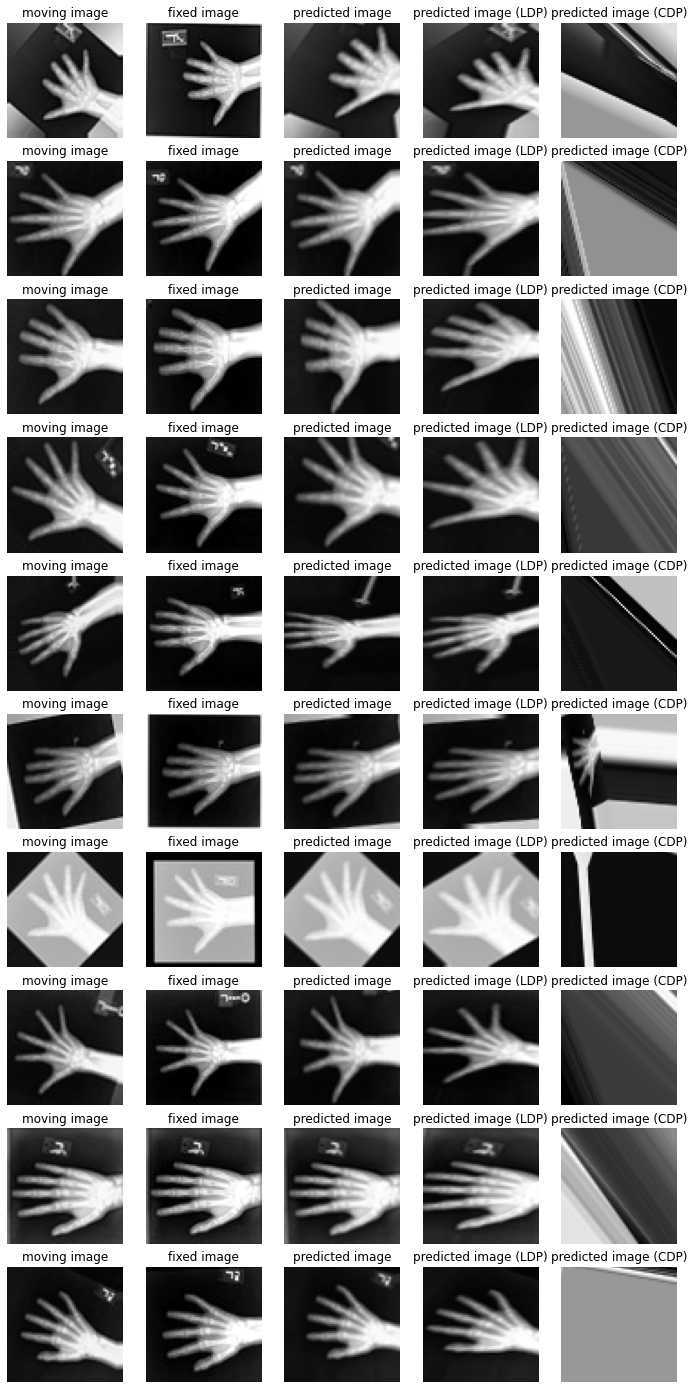

In [25]:
%matplotlib inline
batch_size = 10
plt.subplots(batch_size, 5, figsize=(12, 25))
for b in range(batch_size):
    # moving image
    plt.subplot(batch_size, 5, b * 5 + 1)
    plt.axis('off')
    plt.title("moving image")
    plt.imshow(moving_image[b], cmap="gray")
    # fixed image
    plt.subplot(batch_size, 5, b * 5 + 2)
    plt.axis('off')
    plt.title("fixed image")
    plt.imshow(fixed_image[b], cmap="gray")
    # warped moving
    plt.subplot(batch_size, 5, b * 5 + 3)
    plt.axis('off')
    plt.title("predicted image")
    plt.imshow(pred_image[b], cmap="gray")
    # warped moving LDP
    plt.subplot(batch_size, 5, b * 5 + 4)
    plt.axis('off')
    plt.title("predicted image (LDP)")
    plt.imshow(pred_image_LDP[b], cmap="gray")
    # warped moving CDP
    plt.subplot(batch_size, 5, b * 5 + 5)
    plt.axis('off')
    plt.title("predicted image (CDP)")
    plt.imshow(pred_image_CDP[b], cmap="gray")
plt.axis('off')
plt.show()